## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [329]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [330]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [331]:
from nndl import Softmax

In [332]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [333]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [334]:
print(loss)

2.3277607028048943


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Our weights are initialized randomly which means there is an equal change to select each of the classes. If we take the negative log of the probability which is 1/10, we get approximately 2.3

#### Softmax gradient

In [262]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -4.435578 analytic: -4.435578, relative error: 1.420914e-08
numerical: 0.098406 analytic: 0.098406, relative error: 3.004229e-07
numerical: 0.057334 analytic: 0.057335, relative error: 4.841612e-07
numerical: 2.413431 analytic: 2.413431, relative error: 1.240762e-08
numerical: 1.516859 analytic: 1.516859, relative error: 1.164208e-08
numerical: 1.968279 analytic: 1.968278, relative error: 6.281355e-08
numerical: 0.825006 analytic: 0.825006, relative error: 1.773600e-08
numerical: 0.226202 analytic: 0.226202, relative error: 3.989259e-08
numerical: -0.687165 analytic: -0.687165, relative error: 5.147918e-08
numerical: 2.508454 analytic: 2.508454, relative error: 7.669400e-09


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [263]:
import time

In [317]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 1.8141769534270324 / 139.81619437540215 computed in 8.72600245475769s
Vectorized loss / grad: 1.8141769534270331 / 139.81619437540215 computed in 0.008007287979125977s
difference in loss / grad: -6.661338147750939e-16 /1.1811871690680882e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

We did not do SVM

iteration 0 / 1500: loss 2.3599280562598017
iteration 100 / 1500: loss 2.081038243978451
iteration 200 / 1500: loss 1.9225864942279012
iteration 300 / 1500: loss 1.9940012807229692
iteration 400 / 1500: loss 1.8991429349978781
iteration 500 / 1500: loss 1.8777111514396063
iteration 600 / 1500: loss 1.8689716033020387
iteration 700 / 1500: loss 1.898045969010988
iteration 800 / 1500: loss 1.890300462655831
iteration 900 / 1500: loss 1.9266552323823738
iteration 1000 / 1500: loss 1.8413209892047382
iteration 1100 / 1500: loss 1.8340196387283854
iteration 1200 / 1500: loss 1.9512413596656528
iteration 1300 / 1500: loss 1.888731793210536
iteration 1400 / 1500: loss 1.7614785974155422
That took 6.379985570907593s


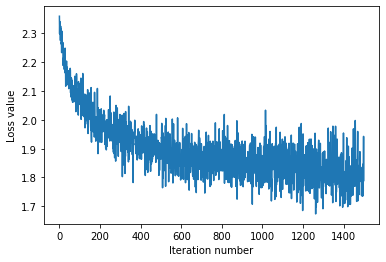

In [318]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [323]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3823877551020408
validation accuracy: 0.395


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [325]:
np.finfo(float).eps

2.220446049250313e-16

In [328]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
validation_accuracy = np.zeros(len(learning_rates))
for i in range(len(learning_rates)):
    softmax.train(X_train, y_train, learning_rate=learning_rates[i], num_iters=1500, verbose=False)
    prediction = softmax.predict(X_val)
    validation_accuracy[i] = np.mean(np.equal(y_val, prediction))
    print('Learning Rate: ',learning_rates[i],', Validation Accuracy: ',validation_accuracy[i])
print('Best Learning Rate: ', learning_rates[np.argmax(validation_accuracy)], 'Best Validation Accuracy: ', np.max(validation_accuracy))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


Learning Rate:  1e-09 , Validation Accuracy:  0.178
Learning Rate:  1e-08 , Validation Accuracy:  0.306
Learning Rate:  1e-07 , Validation Accuracy:  0.382
Learning Rate:  1e-06 , Validation Accuracy:  0.408
Learning Rate:  1e-05 , Validation Accuracy:  0.345
Learning Rate:  0.0001 , Validation Accuracy:  0.295
Learning Rate:  0.001 , Validation Accuracy:  0.087
Learning Rate:  0.01 , Validation Accuracy:  0.087
Best Learning Rate:  1e-06 Best Validation Accuracy:  0.408


# softmax.py code

In [ ]:
import numpy as np


class Softmax(object):

  def __init__(self, dims=[10, 3073]):
    self.init_weights(dims=dims)

  def init_weights(self, dims):
    """
    Initializes the weight matrix of the Softmax classifier.  
    Note that it has shape (C, D) where C is the number of 
    classes and D is the feature size.
    """
    self.W = np.random.normal(size=dims) * 0.0001

  def loss(self, X, y):
    """
    Calculates the softmax loss.
  
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
  
    Inputs:
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
  
    Returns a tuple of:
    - loss as single float
    """

    # Initialize the loss to zero.
    loss = 0.0

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the normalized softmax loss.  Store it as the variable loss.
    #   (That is, calculate the sum of the losses of all the training 
    #   set margins, and then normalize the loss by the number of 
    #   training examples.)
    # ================================================================ #
    N = len(y)
    for i in range(0,N):
        temp1 = np.dot(X[i],self.W.T)[y[i]]
        temp2 = np.sum(np.exp(np.dot(X[i],self.W.T)))
        temp3 = np.log(temp2)
        loss = loss + temp3 - temp1
    loss = loss/N
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss

  def loss_and_grad(self, X, y):
    """
    Same as self.loss(X, y), except that it also returns the gradient.

    Output: grad -- a matrix of the same dimensions as W containing 
      the gradient of the loss with respect to W.
    """

    # Initialize the loss and gradient to zero.
    loss = 0.0
    grad = np.zeros_like(self.W)
  
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and the gradient. Store the gradient
    #   as the variable grad.
    # ================================================================ #
    N = len(y)
    num_classes = self.W.shape[0]
    num_features = self.W.shape[1]
    for i in range(0,N):
        temp1 = np.dot(X[i],self.W.T)[y[i]]
        temp2 = np.sum(np.exp(np.dot(X[i],self.W.T)))
        temp3 = np.log(temp2)
        loss = loss + temp3 - temp1
        t1 = np.exp(np.dot(X[i],self.W.T))
        t2 = t1/np.sum(t1)
        for j in range(0,num_features):
            for k in range(0,num_classes):
                if k == y[i]:
                    grad[k,j] = grad[k,j] + X[i,j]*(t2[k]-1)
                else:
                    grad[k,j] = grad[k,j] + X[i,j]*(t2[k])
    loss = loss/N
    grad = grad/N
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def grad_check_sparse(self, X, y, your_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in these dimensions.
    """
  
    for i in np.arange(num_checks):
      ix = tuple([np.random.randint(m) for m in self.W.shape])
  
      oldval = self.W[ix]
      self.W[ix] = oldval + h # increment by h
      fxph = self.loss(X, y)
      self.W[ix] = oldval - h # decrement by h
      fxmh = self.loss(X,y) # evaluate f(x - h)
      self.W[ix] = oldval # reset
  
      grad_numerical = (fxph - fxmh) / (2 * h)
      grad_analytic = your_grad[ix]
      rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
      print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

  def fast_loss_and_grad(self, X, y):
    """
    A vectorized implementation of loss_and_grad. It shares the same
    inputs and ouptuts as loss_and_grad.
    """
    loss = 0.0
    grad = np.zeros(self.W.shape) # initialize the gradient as zero
  
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and gradient WITHOUT any for loops.
    # ================================================================ #
    N = X.shape[0]
    a = np.matmul(X,self.W.T)
    e_a = np.exp(a)
    e_a_sum = np.sum(e_a,axis=1)
    e_a_div = e_a/e_a_sum[:, np.newaxis]
    e_a_div[np.arange(N), y] -= 1
    a_y_sum = np.sum(np.multiply(self.W[y], X), axis=1)
    log_sum = np.log(e_a_sum)
    loss = np.sum(log_sum - a_y_sum) / N
    grad = np.matmul(e_a_div.T,X)/N
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in np.arange(num_iters):
      X_batch = None
      y_batch = None

      # ================================================================ #
      # YOUR CODE HERE:
      #   Sample batch_size elements from the training data for use in 
      #     gradient descent.  After sampling,
      #     - X_batch should have shape: (dim, batch_size)
      #     - y_batch should have shape: (batch_size,)
      #   The indices should be randomly generated to reduce correlations
      #   in the dataset.  Use np.random.choice.  It's okay to sample with
      #   replacement.
      # ================================================================ #
      i = np.random.choice(X.shape[0], batch_size, replace=True)
      X_batch = X[i]
      y_batch = y[i]
      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      # evaluate loss and gradient
      loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
      loss_history.append(loss)

      # ================================================================ #
      # YOUR CODE HERE:
      #   Update the parameters, self.W, with a gradient step 
      # ================================================================ #
      self.W = self.W - learning_rate*grad

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Inputs:
    - X: N x D array of training data. Each row is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    # ================================================================ #
    # YOUR CODE HERE:
    #   Predict the labels given the training data.
    # ================================================================ #
    y_pred = np.argmax(np.dot(X,self.W.T),axis = 1)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred

